In [2]:
pip install ktrain

In [3]:
pip install tensorflow

In [4]:
pip install nltk

In [5]:
import ktrain
import pandas as pd
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import numpy as np

In [6]:
issues = pd.read_csv("issues.csv")

In [7]:
issues["title_body"] = issues["title"] + issues["body"]

In [8]:
issues['title_body'] = issues['title_body'].str.lower()

In [9]:
questions = issues[issues["label"] == "question"]

In [10]:
non_questions = issues[issues["label"] == "non-question"]

In [11]:
non_questions = non_questions.sample(len(questions))

In [12]:
issues = pd.concat([questions, non_questions], ignore_index=True)

In [13]:
def remove_unused_chars():
  remove = ["-", ">", "<", "[", "]", "`", "´", "#", "=", "{", "}", ",", ".", "!", "?", ";", "/", "+", "(", ")", ":", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", '\"', "'", "^", "\\", "&", "%", "*", "@", '</s>', "|", "\n", "\t"]
  for r in remove:
    issues["title_body"] = issues["title_body"].str.replace(r, "")

In [14]:
remove_unused_chars()

In [15]:
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
------------------------------------------------------------
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(issues)
lemmatized_text_list = []

for row in range(0, nrows):
    
    lemmatized_list = []
    
    text = issues.loc[row]["title_body"]
    text_words = str(text).split(" ")

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    lemmatized_text = " ".join(lemmatized_list)
    
    lemmatized_text_list.append(lemmatized_text)

In [17]:
issues["title_body"] = lemmatized_text_list

In [18]:
remove_unused_chars()

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    issues["title_body"] = issues["title_body"].str.replace(regex_stopword, '')

In [21]:
remove_unused_chars()

In [22]:
(x_train, y_train) , (x_test, y_test), preproc = ktrain.text.texts_from_df(issues, text_column="title_body", preprocess_mode="bert", label_columns=["label"], val_pct=0.3)

['non-question', 'question']
     non-question  question
46            0.0       1.0
169           1.0       0.0
160           1.0       0.0
144           1.0       0.0
76            0.0       1.0
['non-question', 'question']
     non-question  question
13            0.0       1.0
159           1.0       0.0
92            0.0       1.0
54            0.0       1.0
91            0.0       1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [23]:
classifier = ktrain.text.text_classifier(name="bert", train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [24]:
learner = ktrain.get_learner(classifier, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=12)

In [25]:
learner.fit_onecycle(2e-5, 7)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/7
13/13 [==============================] - 480s 36s/step - loss: 0.6923 - accuracy: 0.4846 - val_loss: 0.6234 - val_accuracy: 0.6429
Epoch 2/7
13/13 [==============================] - 454s 35s/step - loss: 0.6469 - accuracy: 0.6462 - val_loss: 0.6171 - val_accuracy: 0.6071
Epoch 3/7
13/13 [==============================] - 455s 35s/step - loss: 0.5688 - accuracy: 0.7615 - val_loss: 0.5595 - val_accuracy: 0.7679
Epoch 4/7
13/13 [==============================] - 451s 35s/step - loss: 0.5012 - accuracy: 0.7846 - val_loss: 0.7616 - val_accuracy: 0.5000
Epoch 5/7
13/13 [==============================] - 450s 35s/step - loss: 0.4769 - accuracy: 0.8154 - val_loss: 0.6142 - val_accuracy: 0.7143
Epoch 6/7
13/13 [==============================] - 450s 35s/step - loss: 0.2988 - accuracy: 0.9385 - val_loss: 0.5767 - val_accuracy: 0.7143
Epoch 7/7
13/13 [==============================] - 451s 35s/step - loss: 0.2054 - accuracy:

In [26]:
learner.evaluate((x_test, y_test))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70        26
           1       0.75      0.70      0.72        30

    accuracy                           0.71        56
   macro avg       0.71      0.72      0.71        56
weighted avg       0.72      0.71      0.71        56



array([[19,  7],
       [ 9, 21]])

In [27]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [28]:
predictor.get_classes()

['non-question', 'question']

In [ ]:
learner.lr_find()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/ktrain/core.py:566: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  warnings.warn('max_epochs is being set to 5 since steps per epoch is small. ' +\


Epoch 1/5
17/17 [==============================] - 399s 23s/step - loss: 0.7608 - accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - 397s 23s/step - loss: 0.7407 - accuracy: 0.5000
Epoch 3/5
17/17 [==============================] - 396s 23s/step - loss: 0.8674 - accuracy: 0.4846
Epoch 4/5
17/17 [==============================] - 396s 23s/step - loss: 2.9881 - accuracy: 0.4692
Epoch 5/5
17/17 [==============================] - 146s 8s/step - loss: 29.7385 - accuracy: 0.5417


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


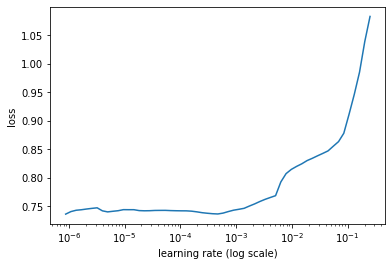

In [ ]:
learner.lr_plot()